In [1]:
!nvidia-smi  --query-gpu=name,memory.total,memory.used --format=csv,noheader

NVIDIA GeForce GTX 1060 6GB, 6144 MiB, 563 MiB


Coded by B.Heddle, E. Porter and N. Wong

In [26]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, roc_curve

Label_encoder = LabelEncoder()

# Load the train data_trainset
data_train = pd.read_csv('fraudTest.csv')
pd.set_option('display.max_columns', None)

#Convert Gender
gender_conversion = {'F': 0, 'M': 1}
data_train['gender'] = data_train['gender'].map(gender_conversion)

data_train['name'] = data_train['first'] + " " + data_train['last']
data_train['address'] = data_train['street'] + ", " + data_train['city'] + ", " + data_train['state']

#Convert first name
data_train['first#'] = Label_encoder.fit_transform(data_train['first'])

#Convert last  name
data_train['last#'] = Label_encoder.fit_transform(data_train['last'])

#Convert first name + last name
data_train['name#'] = Label_encoder.fit_transform(data_train['name'])

#data_train['age'] = 2024 - pd.to_numeric(data_train['dob'].str[:4]) 

#Convert Job
data_train['job#'] = Label_encoder.fit_transform(data_train['job'])

data_train['merchant#'] = Label_encoder.fit_transform(data_train['merchant'])

data_train['category#'] = Label_encoder.fit_transform(data_train['category'])


data_train['street#'] = Label_encoder.fit_transform(data_train['street'])
data_train['city#'] = Label_encoder.fit_transform(data_train['city'])
data_train['state#'] = Label_encoder.fit_transform(data_train['state'])

data_train['address#'] = Label_encoder.fit_transform(data_train['address'])

data_train['trans_num'] = Label_encoder.fit_transform(data_train['trans_num'])

def calculate_age(dob_str):
    dob = datetime.strptime(dob_str, '%Y-%m-%d')
    today = datetime.today()
    age = today.year - dob.year - ((today.month, today.day) < (dob.month, dob.day))
    return age

# Apply the function to the 'dob' column to create a new 'age' column
data_train['age'] = data_train['dob'].apply(calculate_age)

# Function to calculate distance using Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
    
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c  # Distance in kilometers

# Calculate distance for each row
data_train['distance_km'] = haversine(data_train['lat'], data_train['long'], data_train['merch_lat'], data_train['merch_long'])


data_train = data_train.drop(columns=['first', 'last', 'name', 'address','street', 'street', 'city', 'state', 'category', 'job', 'trans_date_trans_time', 'Unnamed: 0', 'dob','merchant'])

#data_train = data_train.drop(columns=['trans_date_trans_time','Unnamed: 0', 'dob'])# 'Unnamed: 0'])



data_train.head()

,cc_num,amt,gender,zip,lat,long,city_pop,trans_num,unix_time,merch_lat,merch_long,is_fraud,first#,last#,name#,job#,merchant#,category#,street#,city#,state#,address#,age,distance_km
0,2291163933867244,2.86,1,29209,33.9659,-80.9355,333497,98699,1371816865,33.986391,-81.200714,0,151,115,377,275,319,10,341,157,39,341,56,24.561462
1,3573030041201292,29.84,0,84002,40.3207,-110.4360,302,108785,1371816873,39.450498,-109.960431,0,163,457,428,392,591,10,354,16,43,354,34,104.925092
2,3598215285024754,41.28,0,11710,40.6729,-73.5365,34496,433979,1371816893,40.495810,-74.196111,0,24,249,70,259,611,5,865,61,33,865,54,59.080078
3,3591919803438423,60.05,1,32780,28.5697,-80.8191,54767,71993,1371816915,28.812398,-80.883061,0,42,457,109,407,222,9,320,764,8,320,37,27.698567
4,3526826139003047,3.19,1,49632,44.2529,-85.0170,1126,190585,1371816917,44.959148,-85.884734,0,247,261,678,196,292,13,548,247,21,548,69,104.335106


In [27]:
# Load the test dataset
data_test = pd.read_csv('fraudTest.csv')
pd.set_option('display.max_columns', None)


#Convert Gender
gender_conversion = {'F': 0, 'M': 1}
data_test['gender'] = data_test['gender'].map(gender_conversion)

data_test['name'] = data_test['first'] + " " + data_test['last']
data_test['address'] = data_test['street'] + ", " + data_test['city'] + ", " + data_test['state']

#Convert first name
data_test['first#'] = Label_encoder.fit_transform(data_test['first'])

#Convert last  name
data_test['last#'] = Label_encoder.fit_transform(data_test['last'])

#Convert first name + last name
data_test['name#'] = Label_encoder.fit_transform(data_test['name'])

#data_test['age'] = 2024 - pd.to_numeric(data_test['dob'].str[:4]) 

#Convert Job
data_test['job#'] = Label_encoder.fit_transform(data_test['job'])

data_test['merchant#'] = Label_encoder.fit_transform(data_test['merchant'])

data_test['category#'] = Label_encoder.fit_transform(data_test['category'])


data_test['street#'] = Label_encoder.fit_transform(data_test['street'])
data_test['city#'] = Label_encoder.fit_transform(data_test['city'])
data_test['state#'] = Label_encoder.fit_transform(data_test['state'])

data_test['address#'] = Label_encoder.fit_transform(data_test['address'])

data_test['trans_num'] = Label_encoder.fit_transform(data_test['trans_num'])

def calculate_age(dob_str):
    dob = datetime.strptime(dob_str, '%Y-%m-%d')
    today = datetime.today()
    age = today.year - dob.year - ((today.month, today.day) < (dob.month, dob.day))
    return age

# Apply the function to the 'dob' column to create a new 'age' column
data_test['age'] = data_test['dob'].apply(calculate_age)

# Function to calculate distance using Haversine formula
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in kilometers
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
    
    dlat = lat2_rad - lat1_rad
    dlon = lon2_rad - lon1_rad
    
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c  # Distance in kilometers

# Calculate distance for each row
data_test['distance_km'] = haversine(data_test['lat'], data_test['long'], data_test['merch_lat'], data_test['merch_long'])


data_test = data_test.drop(columns=['first', 'last', 'name', 'address','street', 'street', 'city', 'state', 'category', 'job', 'trans_date_trans_time', 'Unnamed: 0', 'dob','merchant'])
#data_test = data_test.drop(columns=['trans_date_trans_time','Unnamed: 0', 'dob'])# 'Unnamed: 0'])



data_test.head()

,cc_num,amt,gender,zip,lat,long,city_pop,trans_num,unix_time,merch_lat,merch_long,is_fraud,first#,last#,name#,job#,merchant#,category#,street#,city#,state#,address#,age,distance_km
0,2291163933867244,2.86,1,29209,33.9659,-80.9355,333497,98699,1371816865,33.986391,-81.200714,0,151,115,377,275,319,10,341,157,39,341,56,24.561462
1,3573030041201292,29.84,0,84002,40.3207,-110.4360,302,108785,1371816873,39.450498,-109.960431,0,163,457,428,392,591,10,354,16,43,354,34,104.925092
2,3598215285024754,41.28,0,11710,40.6729,-73.5365,34496,433979,1371816893,40.495810,-74.196111,0,24,249,70,259,611,5,865,61,33,865,54,59.080078
3,3591919803438423,60.05,1,32780,28.5697,-80.8191,54767,71993,1371816915,28.812398,-80.883061,0,42,457,109,407,222,9,320,764,8,320,37,27.698567
4,3526826139003047,3.19,1,49632,44.2529,-85.0170,1126,190585,1371816917,44.959148,-85.884734,0,247,261,678,196,292,13,548,247,21,548,69,104.335106


In [28]:
fraud_rf = RandomForestClassifier(n_estimators=300, # Number of trees to train
                       criterion='gini', # How to train the trees. Also supports entropy.
                       max_depth=None, # Max depth of the trees. Not necessary to change.
                       min_samples_split=5, # Minimum samples to create a split.
                       min_samples_leaf=0.0001, # Minimum samples in a leaf. Accepts fractions for %. This is 0.1% of sample.
                       min_weight_fraction_leaf=0.0, # Same as above, but uses the class weights.
                       max_features='log2', # Maximum number of features per split (not tree!) by default is sqrt(vars)
                       max_leaf_nodes=None, # Maximum number of nodes.
                       min_impurity_decrease=0.0001, # Minimum impurity decrease. This is 10^-3.
                       bootstrap=True, # If sample with repetition. For large samples (>100.000) set to false.
                       oob_score=True,  # If report accuracy with non-selected cases.
                       n_jobs=-1, # Parallel processing. Set to -1 for all cores. Watch your RAM!!
                       random_state=20190305, # Seed
                       verbose=1, # If to give info during training. Set to 0 for silent training.
                       warm_start=False, # If train over previously trained tree.
                       class_weight='balanced'
                                    )

In [29]:
X_train = data_train.drop(columns=['is_fraud'], axis=1)
y_train = data_train['is_fraud']

X_test = data_test.drop(columns=['is_fraud'], axis=1)
y_test = data_test['is_fraud']


fraud_rf.fit(X_train,y_train)
rf_pred_class_test = fraud_rf.predict(X_test)
rf_probs_test = fraud_rf.predict_proba(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   29.1s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.5s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    0.9s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.5s
[Parallel(n_jobs=20)]: Done 300 out of 300 | elapsed:    0.9s finished


In [30]:
from sklearn.metrics import  classification_report
# Evaluation
print("Random Forest 100 Trees ( All Features)")
print("Accuracy:", accuracy_score(y_test, rf_pred_class_test))
print("AUC Score:", roc_auc_score(y_test, rf_probs_test[:, 1]))
print("\nClassification Report:\n", classification_report(y_test, rf_pred_class_test))


Random Forest 100 Trees ( All Features)
Accuracy: 0.9814456586872142
AUC Score: 0.997918803080534

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    553574
           1       0.17      0.99      0.29      2145

    accuracy                           0.98    555719
   macro avg       0.59      0.99      0.64    555719
weighted avg       1.00      0.98      0.99    555719



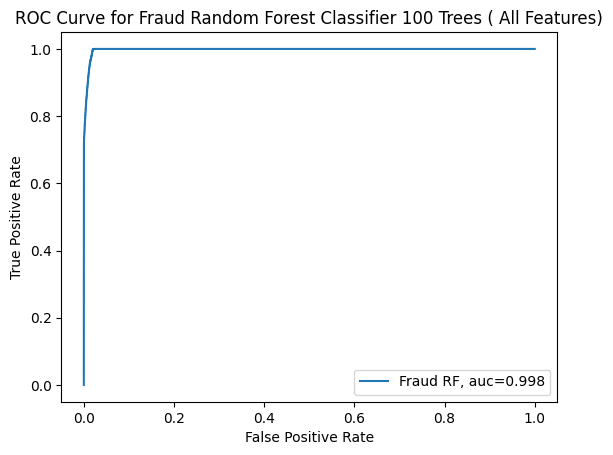

In [31]:
# Calculate the FPR, TPR, and thresholds for the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, rf_probs_test[:, 1])

# Calculate the AUC score using predicted probabilities (for the positive class)
auc = np.round(roc_auc_score(y_true= y_test, y_score=rf_probs_test[:, 1]), decimals=3)

# Create and show the plot
plt.plot(fpr, tpr, label="Fraud RF, auc=" + str(auc))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc=4)
plt.title("ROC Curve for Fraud Random Forest Classifier 100 Trees ( All Features)")
plt.show()

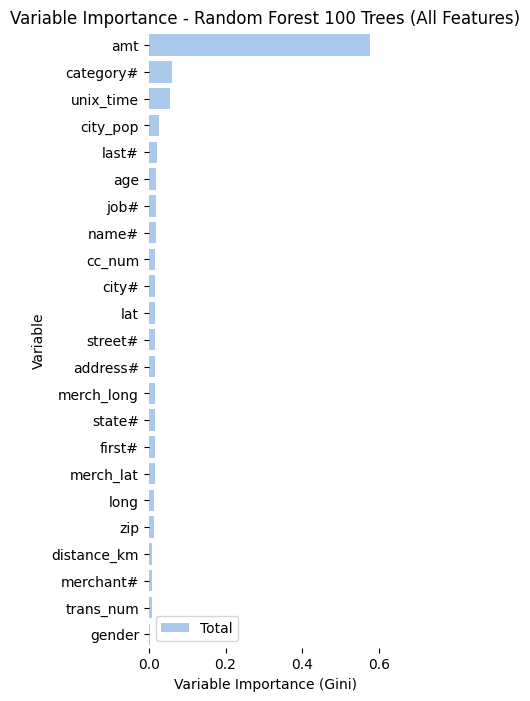

In [32]:
import seaborn as sns
importances = fraud_rf.feature_importances_
indices = np.argsort(importances)[::-1] 
n = X_train

f, ax = plt.subplots(figsize=(3, 8))
plt.title("Variable Importance - Random Forest 100 Trees (All Features)")
sns.set_color_codes("pastel")
sns.barplot(y=[n.columns[i] for i in indices], x=importances[indices], 
            label="Total", color="b")
ax.set(ylabel="Variable",
       xlabel="Variable Importance (Gini)")
sns.despine(left=True, bottom=True)